# Call Annotations

In [1]:
import os
import numpy as np
import decoupler as dc
import pandas as pd
import scanpy as sc
import squidpy as sq
import mudata as mu
import liana as li
from liana.mt import lr_basis, basis

In [2]:
from utils import run_rf_auc

In [3]:
data_dir = os.path.join('..', '..', 'data', 'wu_et_al')
dataset_names = ['1142243F', '1160920F', 'CID4290', 'CID44971', 'CID4535'] # 'CID4465' really unbalanced

In [4]:
function_names = li.mt.sp.show_functions()['name']
function_names = list(function_names[~function_names.str.contains('masked')]) + ['masked_spearman']

In [5]:
function_names

['pearson', 'spearman', 'cosine', 'jaccard', 'morans', 'masked_spearman']

In [6]:
# load map of genes to cytosig signatures
cytosig_map = pd.read_csv('../cytosig_map.csv')
cytosig_map['signature'] = 'S_'+cytosig_map['signature']
# Cytokine expr to Cytosig Siagntures interactions
interactions = list(zip(cytosig_map['gene'], cytosig_map['signature']))

cytosig = pd.read_csv("https://raw.githubusercontent.com/data2intelligence/CytoSig/master/CytoSig/signature.centroid", sep="\t")
cytosig = cytosig.unstack().reset_index().rename(columns={'level_0':'source', 'level_1':'target', 0:'weight'})
cytosig['source'] = 'S_' + cytosig['source']

Run on all data

In [7]:
for dataset_name in dataset_names:
    adata = sc.read_h5ad(os.path.join(data_dir, f"{dataset_name}.h5ad"))
    
    print(adata.obs['Classification'].value_counts())
    
    adata.uns['function_names'] = function_names
    
    # to binary
    adata.obs['Classification'][adata.obs['Classification'].isna()] = 'Artefact'
    adata.obs['spot_label'] = adata.obs['Classification'].str.contains('cancer').astype(int)
    
    # Preprocess
    sc.pp.filter_cells(adata, min_genes=400)
    sc.pp.filter_genes(adata, min_cells=20)

    adata.layers["counts"] = adata.X.copy()
    sc.pp.normalize_total(adata, inplace=True)
    
    sc.pp.log1p(adata)
    # spatial weights
    sq.gr.spatial_neighbors(adata, n_rings=1, coord_type="grid", n_neighs=6)
    
    # Cytokine activities
    dc.run_mlm(adata, cytosig, use_raw=False)
    
    mdata = mu.MuData({'rna': adata,
                   "cytosig": li.fun.obsm_to_adata(adata, "mlm_estimate")})
    mdata.uns = adata.uns
    mdata.obsm = adata.obsm
    mdata.obsp = adata.obsp
    mdata.obs = adata.obs
    
    # Run all functions
    for function_name in function_names:
        print(f"Running {function_name}")
        
        lr_basis(adata,
                function_name=function_name,
                obsm_added=function_name, 
                key_added= function_name,
                use_raw=False, 
                proximity_key="spatial_connectivities"
                )
        
        basis(mdata,
            x_mod='rna',
            y_mod='cytosig',
            interactions=interactions,
            function_name=function_name, 
            mod_added=function_name,
            key_added=function_name, 
            proximity_key="spatial_connectivities"
            )
        
        
    # eval LR basis
    run_rf_auc(mdata.mod['rna'], dataset_name)
    os.makedirs(os.path.join(data_dir, 'results'), exist_ok=True)
    performance = adata.uns['performance']
    performance.to_csv(os.path.join(data_dir, 'results', f"{dataset_name}_performance.csv"))
    
    # eval ligand - cytokine interactions
    run_rf_auc(mdata, dataset_name)
    os.makedirs(os.path.join(data_dir, 'results'), exist_ok=True)
    performance = mdata.uns['performance']
    performance.to_csv(os.path.join(data_dir, 'results', f"{dataset_name}_lig_performance.csv"))


Invasive cancer + stroma + lymphocytes    3627
Necrosis                                   568
Stroma                                     445
Artefact                                   119
Lymphocytes                                 15
TLS                                         10
Name: Classification, dtype: int64
Running pearson
Running spearman
Running cosine
Running jaccard
Running morans


/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/liana/method/sp/_spatial_pipe.py:473: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/liana/method/sp/_spatial_pipe.py:473: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Running masked_spearman
Evaluating 1142243F; Fold: 0
Evaluating 1142243F; Fold: 1
Evaluating 1142243F; Fold: 2
Evaluating 1142243F; Fold: 3
Evaluating 1142243F; Fold: 4
Evaluating 1142243F; Fold: 5
Evaluating 1142243F; Fold: 6
Evaluating 1142243F; Fold: 7
Evaluating 1142243F; Fold: 8
Evaluating 1142243F; Fold: 9
Evaluating 1142243F; Fold: 0
Evaluating 1142243F; Fold: 1
Evaluating 1142243F; Fold: 2
Evaluating 1142243F; Fold: 3
Evaluating 1142243F; Fold: 4
Evaluating 1142243F; Fold: 5
Evaluating 1142243F; Fold: 6
Evaluating 1142243F; Fold: 7
Evaluating 1142243F; Fold: 8
Evaluating 1142243F; Fold: 9
Invasive cancer + stroma + lymphocytes      3146
Stroma                                      1132
Normal glands + lymphocytes                  278
Lymphocytes                                  186
Adipose tissue                                83
Artefact                                      48
DCIS                                          12
Cancer trapped in lymphocyte aggregation       9
Name

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/liana/method/sp/_spatial_pipe.py:473: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/liana/method/sp/_spatial_pipe.py:473: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Running masked_spearman
Evaluating 1160920F; Fold: 0
Evaluating 1160920F; Fold: 1
Evaluating 1160920F; Fold: 2
Evaluating 1160920F; Fold: 3
Evaluating 1160920F; Fold: 4
Evaluating 1160920F; Fold: 5
Evaluating 1160920F; Fold: 6
Evaluating 1160920F; Fold: 7
Evaluating 1160920F; Fold: 8
Evaluating 1160920F; Fold: 9
Evaluating 1160920F; Fold: 0
Evaluating 1160920F; Fold: 1
Evaluating 1160920F; Fold: 2
Evaluating 1160920F; Fold: 3
Evaluating 1160920F; Fold: 4
Evaluating 1160920F; Fold: 5
Evaluating 1160920F; Fold: 6
Evaluating 1160920F; Fold: 7
Evaluating 1160920F; Fold: 8
Evaluating 1160920F; Fold: 9
Invasive cancer + stroma                  2082
Invasive cancer + stroma + lymphocytes     215
Stroma                                     122
Artefact                                     7
Name: Classification, dtype: int64
Running pearson
Running spearman
Running cosine
Running jaccard
Running morans


/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/liana/method/sp/_spatial_pipe.py:473: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/liana/method/sp/_spatial_pipe.py:473: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Running masked_spearman
Evaluating CID4290; Fold: 0
Evaluating CID4290; Fold: 1
Evaluating CID4290; Fold: 2
Evaluating CID4290; Fold: 3
Evaluating CID4290; Fold: 4
Evaluating CID4290; Fold: 5
Evaluating CID4290; Fold: 6
Evaluating CID4290; Fold: 7
Evaluating CID4290; Fold: 8
Evaluating CID4290; Fold: 9
Evaluating CID4290; Fold: 0
Evaluating CID4290; Fold: 1
Evaluating CID4290; Fold: 2
Evaluating CID4290; Fold: 3
Evaluating CID4290; Fold: 4
Evaluating CID4290; Fold: 5
Evaluating CID4290; Fold: 6
Evaluating CID4290; Fold: 7
Evaluating CID4290; Fold: 8
Evaluating CID4290; Fold: 9
Invasive cancer + lymphocytes    317
DCIS                             273
Normal + stroma + lymphocytes    240
Stroma                           134
Stroma + adipose tissue          114
Lymphocytes                       81
Artefact                           1
Name: Classification, dtype: int64
Running pearson
Running spearman
Running cosine
Running jaccard
Running morans


/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/liana/method/sp/_spatial_pipe.py:473: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/liana/method/sp/_spatial_pipe.py:473: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Running masked_spearman
Evaluating CID44971; Fold: 0
Evaluating CID44971; Fold: 1
Evaluating CID44971; Fold: 2
Evaluating CID44971; Fold: 3
Evaluating CID44971; Fold: 4
Evaluating CID44971; Fold: 5
Evaluating CID44971; Fold: 6
Evaluating CID44971; Fold: 7
Evaluating CID44971; Fold: 8
Evaluating CID44971; Fold: 9
Evaluating CID44971; Fold: 0
Evaluating CID44971; Fold: 1
Evaluating CID44971; Fold: 2
Evaluating CID44971; Fold: 3
Evaluating CID44971; Fold: 4
Evaluating CID44971; Fold: 5
Evaluating CID44971; Fold: 6
Evaluating CID44971; Fold: 7
Evaluating CID44971; Fold: 8
Evaluating CID44971; Fold: 9
Invasive cancer                                   418
Invasive cancer + lymphocytes                     361
Stroma                                            169
Uncertain                                          73
Lymphocytes                                        69
Artefact                                           23
Adipose tissue                                      8
Invasive cancer + 

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/liana/method/sp/_spatial_pipe.py:473: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/liana/method/sp/_spatial_pipe.py:473: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Running masked_spearman
Evaluating CID4535; Fold: 0
Evaluating CID4535; Fold: 1
Evaluating CID4535; Fold: 2
Evaluating CID4535; Fold: 3
Evaluating CID4535; Fold: 4
Evaluating CID4535; Fold: 5
Evaluating CID4535; Fold: 6
Evaluating CID4535; Fold: 7
Evaluating CID4535; Fold: 8
Evaluating CID4535; Fold: 9
Evaluating CID4535; Fold: 0
Evaluating CID4535; Fold: 1
Evaluating CID4535; Fold: 2
Evaluating CID4535; Fold: 3
Evaluating CID4535; Fold: 4
Evaluating CID4535; Fold: 5
Evaluating CID4535; Fold: 6
Evaluating CID4535; Fold: 7
Evaluating CID4535; Fold: 8
Evaluating CID4535; Fold: 9


Plot Results

In [96]:
import plotnine as p9

In [115]:
## read results
results = os.listdir(os.path.join(data_dir, 'results'))
results = [result for result in results if not result.__contains__('lig')]
results_df = []
for result in results:
    results_df.append(pd.read_csv(os.path.join(data_dir, 'results', result)))
results_df = pd.concat(results_df)

In [117]:
performance = results_df.groupby(['dataset_name', 'function_name']).mean().reset_index()

In [118]:
# rank by dataset_name
performance['rank'] = performance.groupby('dataset_name')['f1'].rank(ascending=False).astype('int')

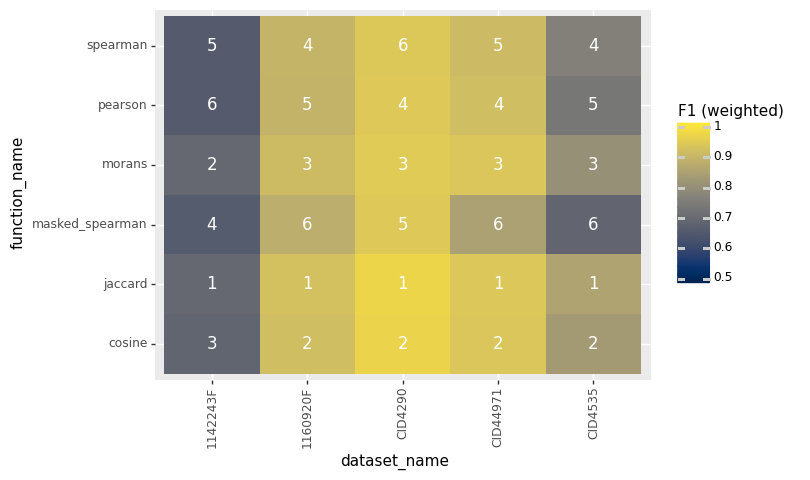

<ggplot: (8755470406134)>

In [119]:
# heatmap plot of function_name, x roc_auc, y f1
(p9.ggplot(performance, p9.aes(x='dataset_name', y='function_name', fill='f1')) + 
 p9.geom_tile() + 
 p9.geom_text(p9.aes(label='rank'), size=12, color='white') +
 p9.theme(axis_text_x=p9.element_text(rotation=90)) + 
 p9.scale_fill_cmap(limits=(0.5, 1), cmap_name='cividis') +
 p9.labs(fill='F1 (weighted)')
 )

mdata

In [ ]:
# scatter plot of function_name, x roc_auc, y f1
p9.ggplot(performance, p9.aes(x='roc_auc', y='f1', colour='function_name')) + p9.geom_point()